# Boston Crime Analysis


In this analysis I will be focusing on the analysis to deduce some predictions and trends in the crime stats.
I will be answering the Following questions:

    Q1. Which are the areas with high crime frequency?
    Q2. Time of the day having highest crime frequency.
    Q3. Is there any trend in the crime frequency?
    Q4. If yes, can predictions be made using this trend?
    Q5. Is it possible to forecast the daily frequency of crimes? How?

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns; sns.set()

style.use('fivethirtyeight')
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

%matplotlib inline

In [9]:
Rawdata = pd.read_csv('crime.csv',encoding='latin-1')

# Dropping "INCIDENT_NUMBER"
Rawdata.drop("INCIDENT_NUMBER",axis=1, inplace=True)

#Separating 'Date' & 'Time' present in 'OCCURED_ON_DATE' coloumn
Rawdata[["DATE","TIME"]]=Rawdata['OCCURRED_ON_DATE'].str.split(" ",expand=True) 
Rawdata.drop("OCCURRED_ON_DATE", axis=1, inplace=True)

print(Rawdata.info())
Rawdata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319073 entries, 0 to 319072
Data columns (total 17 columns):
OFFENSE_CODE           319073 non-null int64
OFFENSE_CODE_GROUP     319073 non-null object
OFFENSE_DESCRIPTION    319073 non-null object
DISTRICT               317308 non-null object
REPORTING_AREA         319073 non-null object
SHOOTING               1019 non-null object
YEAR                   319073 non-null int64
MONTH                  319073 non-null int64
DAY_OF_WEEK            319073 non-null object
HOUR                   319073 non-null int64
UCR_PART               318983 non-null object
STREET                 308202 non-null object
Lat                    299074 non-null float64
Long                   299074 non-null float64
Location               319073 non-null object
DATE                   319073 non-null object
TIME                   319073 non-null object
dtypes: float64(2), int64(4), object(11)
memory usage: 41.4+ MB
None


,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,DATE,TIME
0,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)",2018-09-02,13:00:00
1,1402,Vandalism,VANDALISM,C11,347,NaN,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)",2018-08-21,00:00:00
2,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)",2018-09-03,19:27:00
3,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)",2018-09-03,21:16:00
4,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)",2018-09-03,21:05:00


In [10]:
# Create 2 columes DateFrame
def createdf(c1,d1,c2,d2):
    dic = {c1:d1,c2:d2}
    df = pd.DataFrame(dic)
    return df

In [11]:
temp_df = Rawdata['STREET'].value_counts()
temp_df = temp_df.reset_index()
temp_df.columns = ['Street', 'Count']

<BarContainer object of 10 artists>

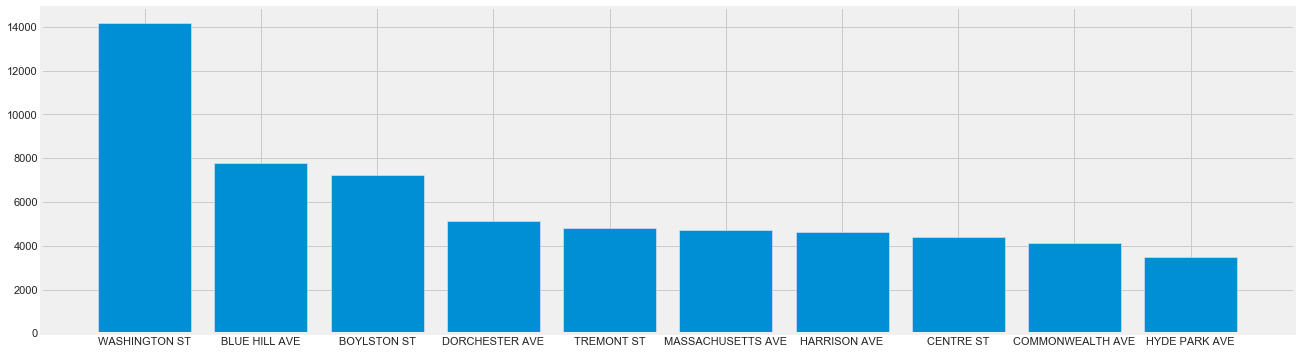

In [12]:
plt.figure(figsize=(20,6))
plt.bar(temp_df['Street'][:10],temp_df['Count'][:10])

So here we can see the 10 Streets in Boston with the highest cime frequency out which 'Washington St' show the highest frequency.
These streetss can be considered as the most unsafe places in the city.

#### Now we try to find the type of crime with highest frequuency and will try to map it with the above 10 cities. 

In [13]:
temp_df = Rawdata['OFFENSE_CODE_GROUP'].value_counts()
temp_df = temp_df.reset_index()
temp_df.columns = ['OFFENSE_GROUP', 'Count']

<BarContainer object of 10 artists>

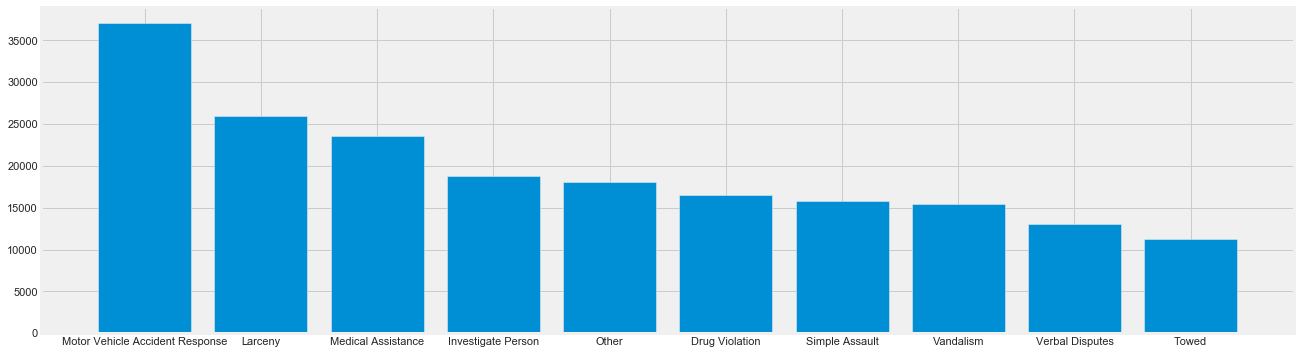

In [14]:
plt.figure(figsize=(20,6))
plt.bar(temp_df['OFFENSE_GROUP'][:10],temp_df['Count'][:10])